# Train

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.datasets.datasets import LSTMDataset, get_dataset
from hython.trainer import train_val
from hython.sampler import SamplerBuilder
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer


import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

In [3]:
surr_input =  "adg1km_eobs.zarr"
dir_surr_input = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_input"

surr_model_output = "demo.pt"
experiment = "exp1" # experiment name

dir_surr_output = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model"


SEED = 1696

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc","actevap"] 

mask_names = ["mask_missing"]


dataset = "LSTMDataset"
# DL model hyper parameters
HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)
TARGET_WEIGHTS = {t:0.5 for t in target_names}

# train/test parameters
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2016-01-01", "2018-12-31")

EPOCHS = 20
BATCH = 256
TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = 150 
SEQ_LENGTH = 360

mask_names = ["mask_missing"]

assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])

# paths
file_surr_input = f"{dir_surr_input}/{surr_input}"

In [4]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
Xd = (
    read_from_zarr(url=file_surr_input, group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(url=file_surr_input, group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=file_surr_input, group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]
TIME_RANGE = Xd.shape[1]
print(TIME_RANGE)

# === READ TEST ===================================================================

Y_test = (
    read_from_zarr(url=file_surr_input, group="y", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .y.sel(feat=target_names)
)
Xd_test = (
    read_from_zarr(url=file_surr_input, group="xd", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .xd.sel(feat=dynamic_names)
)

1096


In [6]:
Y_test.shape

(40140, 1096, 2)

In [7]:
masks = (
    read_from_zarr(url=file_surr_input, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

In [8]:
normalizer_dynamic = Normalizer(method="standardize", type="spacetime")

normalizer_static = Normalizer(method="standardize", type="space")

normalizer_target = Normalizer(method="standardize", type="spacetime")

normalizer_dynamic.compute_stats(Xd)
normalizer_static.compute_stats(Xs)
normalizer_target.compute_stats(Y)

# TODO: save stats, implement caching of stats to save computation

Xd = normalizer_dynamic.normalize(Xd)
Xs = normalizer_static.normalize(Xs)
Y = normalizer_target.normalize(Y)

Xd_test = normalizer_dynamic.normalize(Xd_test)
Y_test = normalizer_target.normalize(Y_test)

compute stats
compute stats
compute stats


In [9]:
train_dataset = get_dataset(dataset)(
    torch.Tensor(Xd.values), torch.Tensor(Y.values), torch.Tensor(Xs.values)
)
test_dataset = get_dataset(dataset)(
    torch.Tensor(Xd_test.values),
    torch.Tensor(Y_test.values),
    torch.Tensor(Xs.values),
)

In [10]:
train_sampler_builder = SamplerBuilder(sampling_method= "regular", sampling_method_kwargs = {"intervals": [4,4], "origin": [0, 0]}, 
                                       minibatch_sampling="random", processing="single-gpu")

test_sampler_builder = SamplerBuilder(sampling_method= "regular", sampling_method_kwargs = {"intervals": [4,4], "origin": [2, 2]}, 
                                      minibatch_sampling="sequential", processing="single-gpu")

In [10]:
train_sampler_builder.initialize(
    shape=SHAPE, mask_missing=masks.values, torch_dataset=train_dataset
)
test_sampler_builder.initialize(
    shape=SHAPE, mask_missing=masks.values, torch_dataset=test_dataset
)

train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

[    0     1     2 ... 40137 40138 40139]
found missing
[    0     1     2 ... 40137 40138 40139]
found missing


In [11]:
len(train_sampler)

966

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH , sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [13]:
for d,y,s in test_loader:
    print(d.shape, y.shape, s.shape)

torch.Size([256, 1096, 3]) torch.Size([256, 6]) torch.Size([256, 1096, 2])
torch.Size([256, 1096, 3]) torch.Size([256, 6]) torch.Size([256, 1096, 2])
torch.Size([256, 1096, 3]) torch.Size([256, 6]) torch.Size([256, 1096, 2])
torch.Size([198, 1096, 3]) torch.Size([198, 6]) torch.Size([198, 1096, 2])


In [14]:
model = CuDNNLSTM(
                  hidden_size=HIDDEN_SIZE, 
                  dynamic_input_size=DYNAMIC_INPUT_SIZE,
                  static_input_size=STATIC_INPUT_SIZE, 
                  output_size=OUTPUT_SIZE
)

In [ ]:
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

In [17]:
trainer = RNNTrainer(
    RNNTrainParams(
               experiment=experiment, 
               temporal_subsampling=TEMPORAL_SUBSAMPLING, 
               temporal_subset=TEMPORAL_SUBSET, 
               seq_length=SEQ_LENGTH, 
               target_names=target_names,
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [18]:
file_surr_output = f"{dir_surr_output}/{experiment}_{surr_model_output}"

In [19]:
# train
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    test_loader,
    EPOCHS,
    opt,
    lr_scheduler,
    file_surr_output,
    device,
    TIME_RANGE,
)

  5%|████▊                                                                                            | 1/20 [00:03<01:06,  3.48s/it]

Copied best model weights!
train loss: 0.334943026304245
val loss: 0.23262612521648407


 10%|█████████▋                                                                                       | 2/20 [00:06<01:00,  3.36s/it]

Copied best model weights!
train loss: 0.2291126549243927
val loss: 0.19504931569099426


 15%|██████████████▌                                                                                  | 3/20 [00:10<00:56,  3.33s/it]

Copied best model weights!
train loss: 0.2037280797958374
val loss: 0.18034091591835022


 20%|███████████████████▍                                                                             | 4/20 [00:13<00:53,  3.32s/it]

Copied best model weights!
train loss: 0.19209489226341248
val loss: 0.17188407480716705


 25%|████████████████████████▎                                                                        | 5/20 [00:16<00:49,  3.31s/it]

Copied best model weights!
train loss: 0.17233218252658844
val loss: 0.15777923166751862


 30%|█████████████████████████████                                                                    | 6/20 [00:19<00:46,  3.32s/it]

train loss: 0.17111092805862427
val loss: 0.16199226677417755


 35%|█████████████████████████████████▉                                                               | 7/20 [00:23<00:43,  3.31s/it]

train loss: 0.16514703631401062
val loss: 0.16428394615650177


 40%|██████████████████████████████████████▊                                                          | 8/20 [00:26<00:39,  3.33s/it]

Copied best model weights!
train loss: 0.15988361835479736
val loss: 0.1514347642660141


 45%|███████████████████████████████████████████▋                                                     | 9/20 [00:29<00:36,  3.32s/it]

Copied best model weights!
train loss: 0.15970999002456665
val loss: 0.14869336783885956


 50%|████████████████████████████████████████████████                                                | 10/20 [00:33<00:33,  3.34s/it]

Copied best model weights!
train loss: 0.1520548313856125
val loss: 0.14865261316299438


 55%|████████████████████████████████████████████████████▊                                           | 11/20 [00:36<00:30,  3.35s/it]

Copied best model weights!
train loss: 0.15567360818386078
val loss: 0.14332056045532227


 60%|█████████████████████████████████████████████████████████▌                                      | 12/20 [00:40<00:26,  3.35s/it]

Copied best model weights!
train loss: 0.1524980366230011
val loss: 0.13846355676651


 65%|██████████████████████████████████████████████████████████████▍                                 | 13/20 [00:43<00:23,  3.36s/it]

train loss: 0.1515013873577118
val loss: 0.14645281434059143


 70%|███████████████████████████████████████████████████████████████████▏                            | 14/20 [00:46<00:20,  3.39s/it]

Copied best model weights!
train loss: 0.1454916000366211
val loss: 0.13520723581314087


 75%|████████████████████████████████████████████████████████████████████████                        | 15/20 [00:50<00:16,  3.39s/it]

train loss: 0.15067853033542633
val loss: 0.14693757891654968


 80%|████████████████████████████████████████████████████████████████████████████▊                   | 16/20 [00:53<00:13,  3.38s/it]

train loss: 0.14916273951530457
val loss: 0.14164432883262634


 85%|█████████████████████████████████████████████████████████████████████████████████▌              | 17/20 [00:56<00:10,  3.38s/it]

Copied best model weights!
train loss: 0.14563961327075958
val loss: 0.1326623260974884


 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 18/20 [01:00<00:06,  3.38s/it]

train loss: 0.14873971045017242
val loss: 0.13747841119766235


 95%|███████████████████████████████████████████████████████████████████████████████████████████▏    | 19/20 [01:03<00:03,  3.38s/it]

train loss: 0.14613090455532074
val loss: 0.14217986166477203


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.36s/it]

Copied best model weights!
train loss: 0.13625884056091309
val loss: 0.13256071507930756


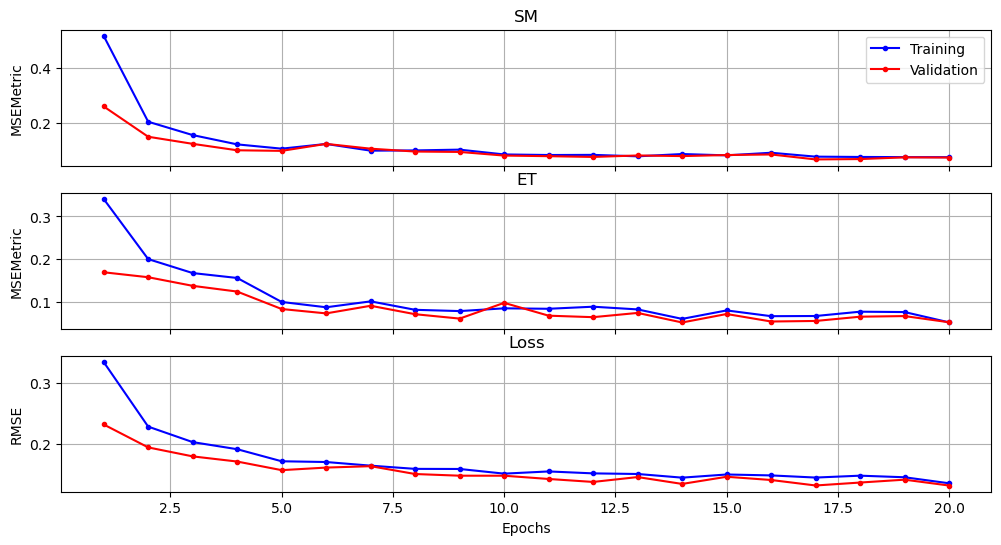

In [21]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('SM')
axs[0].set_ylabel(metric_fn.__class__.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
axs[1].set_title('ET')
axs[1].set_ylabel(metric_fn.__class__.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[2].set_title('Loss')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)